In [1]:
from main import setup
import yaml
import pathlib
import torch
import matplotlib.pyplot as plt

INFO:2024-01-18 10:32:31 1531:1531 init.cpp:158] If you see CUPTI_ERROR_INSUFFICIENT_PRIVILEGES, refer to https://developer.nvidia.com/nvidia-development-tools-solutions-err-nvgpuctrperm-cupti


In [2]:
def load(path, episode):
    hparam = path + "/hparam.yaml"
    config = yaml.safe_load(open(hparam))
    sampler, optim, scheduler = setup(config)

    progress = torch.load(f"{path}/progress{'_' + str(episode) if episode != None else ''}.pth")

    if "ln_a_0" in progress["sampler"]:
        del progress["sampler"]["ln_a_0"]
    
    if "ln_a_1" in progress["sampler"]:
        del progress["sampler"]["ln_a_1"]

    sampler.load_state_dict(progress["sampler"])
    optim.load_state_dict(progress["optim"])

    return config, sampler, optim


In [3]:
from mcmd.densities import DoubleWell


log_norm = DoubleWell(5, 5, 4).log_norm()
print(log_norm)

tensor(-0.5413, device='cuda:0')


In [4]:
ln_rnd = torch.tensor([0, 1.0, 2.0])
B = ln_rnd.shape[0]
device = ln_rnd.device

torch.vstack([ln_rnd, torch.zeros(B).to(device)]).logsumexp(dim=0)

# torch.tensor(2.0).log()
          


tensor([0.6931, 1.3133, 2.1269])

In [28]:
config, sampler, optim = load("/home/brianlck/code/code/dissertation/logs/dw/24-01-08-16:56:25", None)
samples = sampler.sample(2000, loss_fn="var", repel=True, a=0.0)
config['loss_fn'], config['repel'], samples.ln_z, samples.jensen(log_norm), samples.elbo, samples.ess(), samples.loss


torch.Size([2000])
torch.Size([2000])


('var',
 True,
 tensor(-5.3813, device='cuda:0', grad_fn=<SubBackward0>),
 tensor(0.3450, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(-26.0902, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(129.6144, device='cuda:0', grad_fn=<VarBackward0>))

In [15]:
samples.ln_rnd.var(), samples.ln_rnd.max(), samples.ln_rnd.min()

(tensor(153.0308, device='cuda:0', grad_fn=<VarBackward0>),
 tensor(2.5379, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-68.2305, device='cuda:0', grad_fn=<MinBackward1>))

In [25]:
# config, sampler, optim = load("/home/brianlck/code/code/dissertation/logs/dw/24-01-08-16:56:25", 2000)
# config, sampler, optim = load("/home/brianlck/code/code/dissertation/logs/dw/23-12-31-19:07:06", None)
config, sampler, optim = load("/home/brianlck/code/code/dissertation/logs/dw/23-12-25-22:14:27", None)
samples2 = sampler.sample(3000, loss_fn="var", repel=False, a=None)
config['loss_fn'], config['repel'], samples2.ln_z, samples2.jensen(log_norm), samples2.elbo, samples2.ess(), samples2.loss


torch.Size([3000])
torch.Size([3000])


('var',
 False,
 tensor(-44.6187, device='cuda:0', grad_fn=<SubBackward0>),
 tensor(0.3466, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(-49.7272, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(10.5680, device='cuda:0', grad_fn=<VarBackward0>))

In [19]:
# config, sampler, optim = load("/home/brianlck/code/code/dissertation/logs/dw/24-01-01-02:15:38", None)
# config, sampler, optim = load("/home/brianlck/code/code/dissertation/logs/dw/24-01-01-22:38:49", None)
config, sampler, optim = load("/home/brianlck/code/code/dissertation/logs/dw/23-12-26-05:53:23",  None)
samples3 = sampler.sample(3000, loss_fn="var", a=None, repel=False)
config['loss_fn'], config['repel'], samples3.ln_z, samples3.jensen(log_norm), samples3.elbo, samples3.ess(), samples3.loss

torch.Size([3000])
torch.Size([3000])


('mean',
 False,
 tensor(-2.9256, device='cuda:0', grad_fn=<SubBackward0>),
 tensor(0.3129, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(-5.0192, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0400, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(6.5463, device='cuda:0', grad_fn=<VarBackward0>))

In [27]:
from mcmd.numericals import effective_sample_size
effective_sample_size(samples2.ln_rnd + log_norm), effective_sample_size(samples.ln_rnd + log_norm), effective_sample_size(samples3.ln_rnd + log_norm)

(tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0400, device='cuda:0', grad_fn=<DivBackward0>))

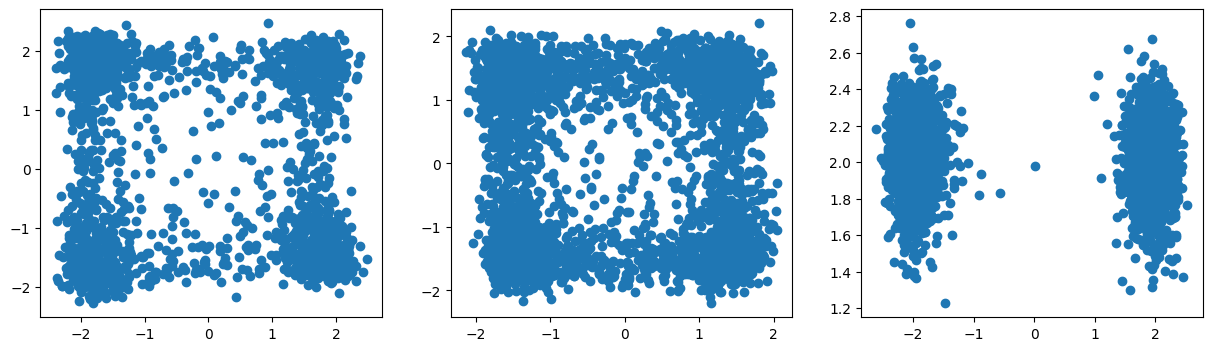

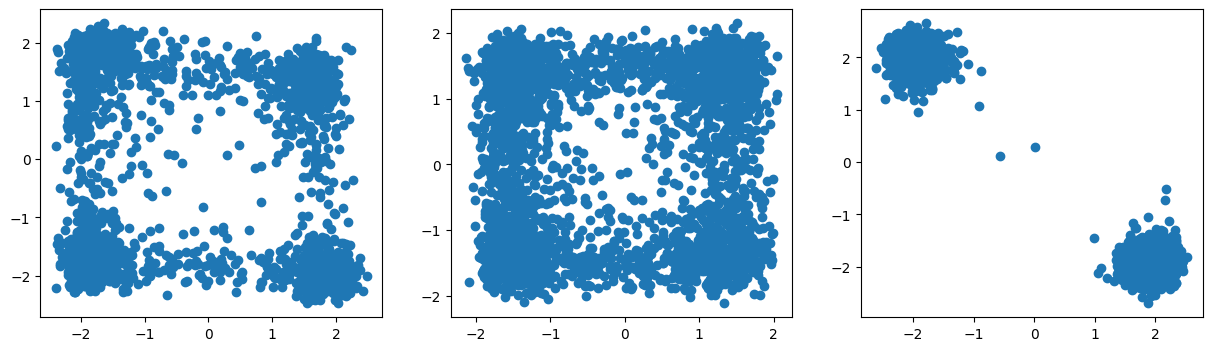

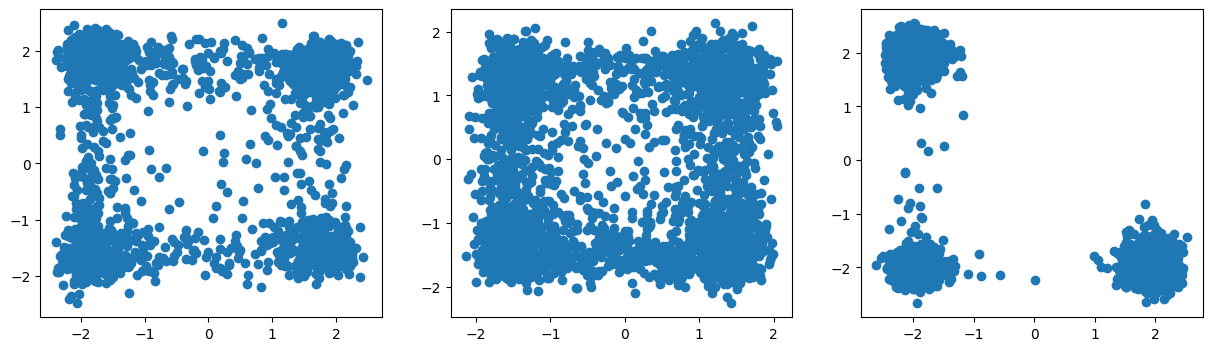

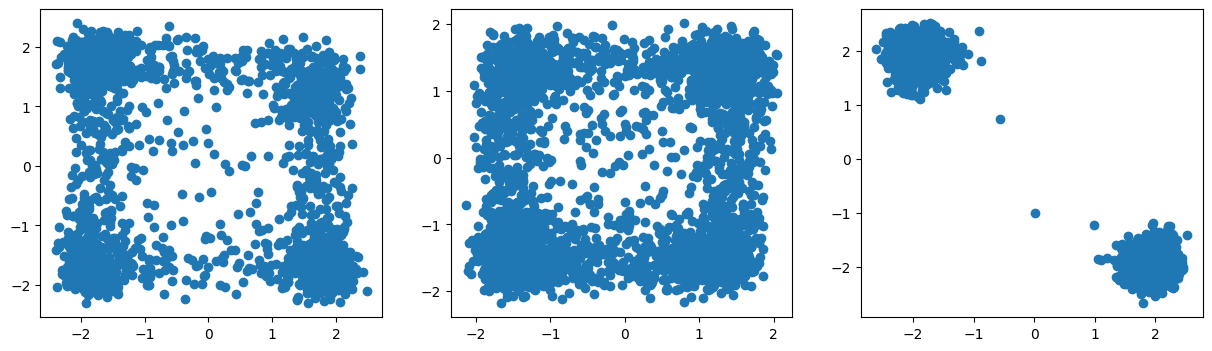

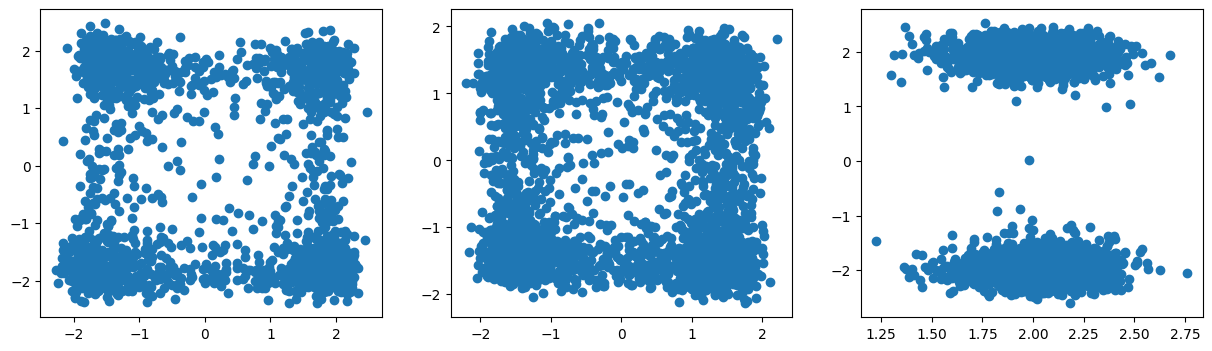

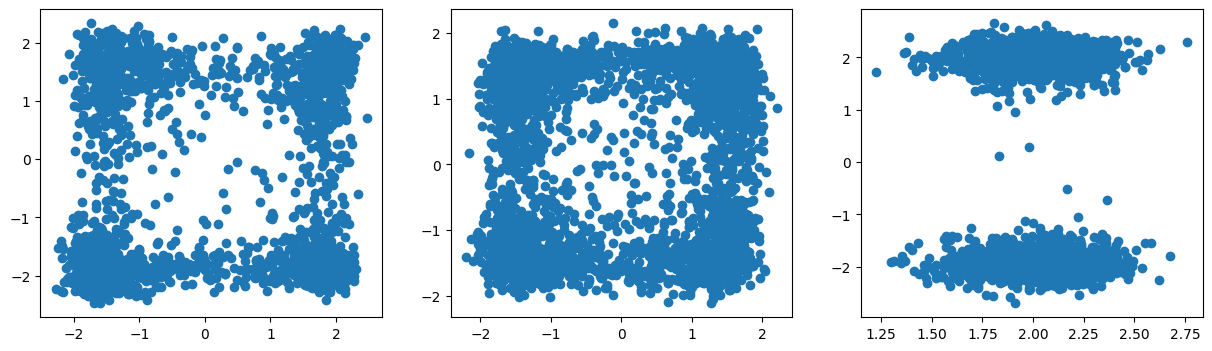

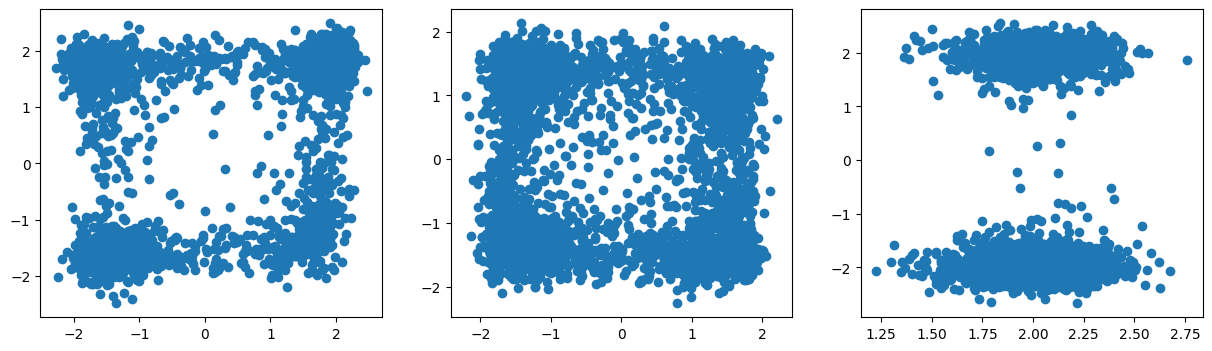

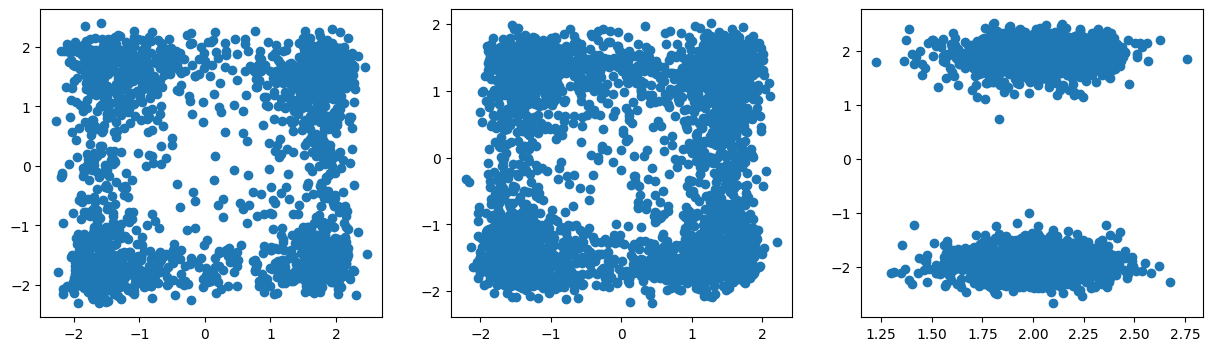

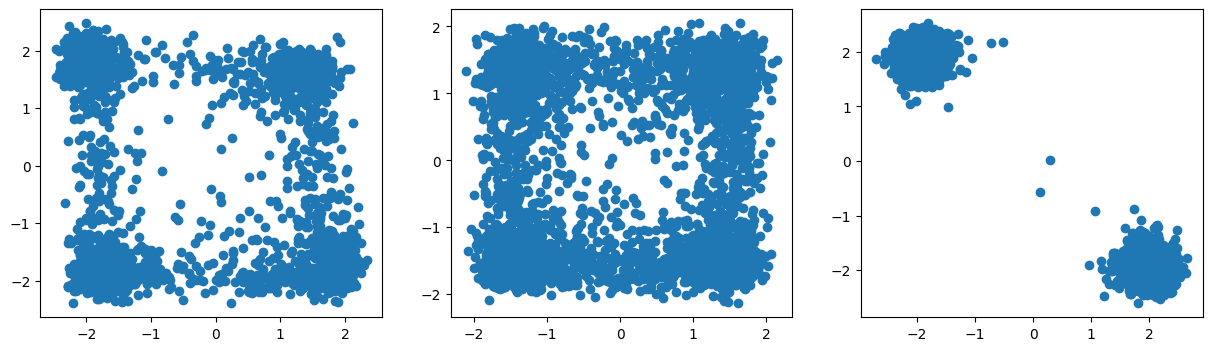

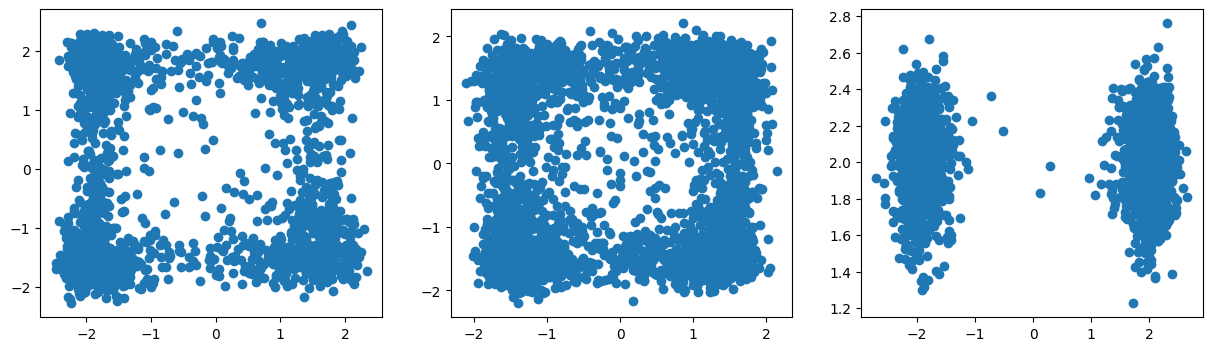

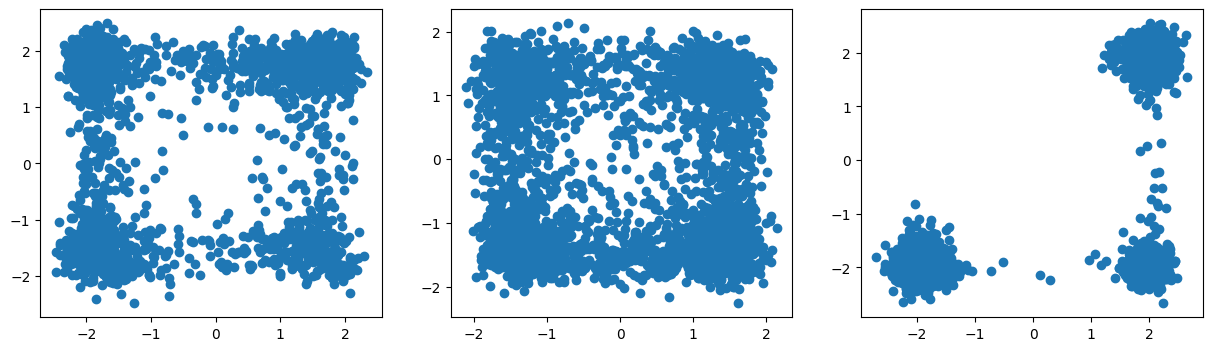

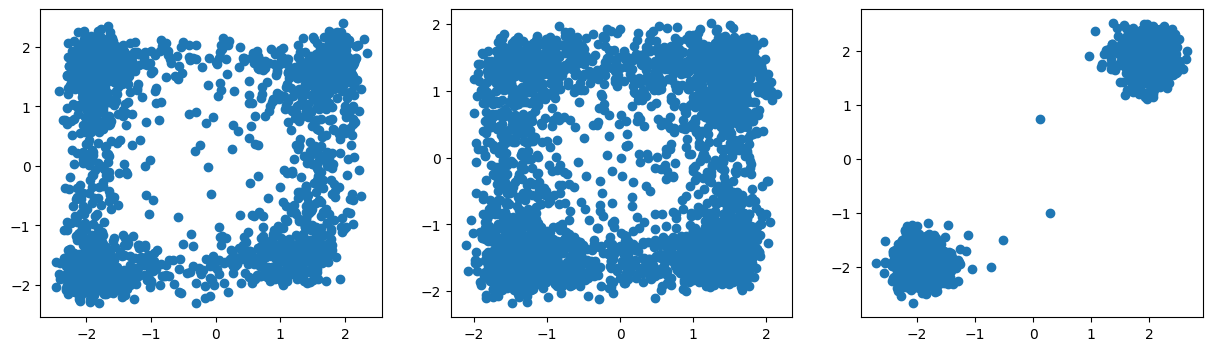

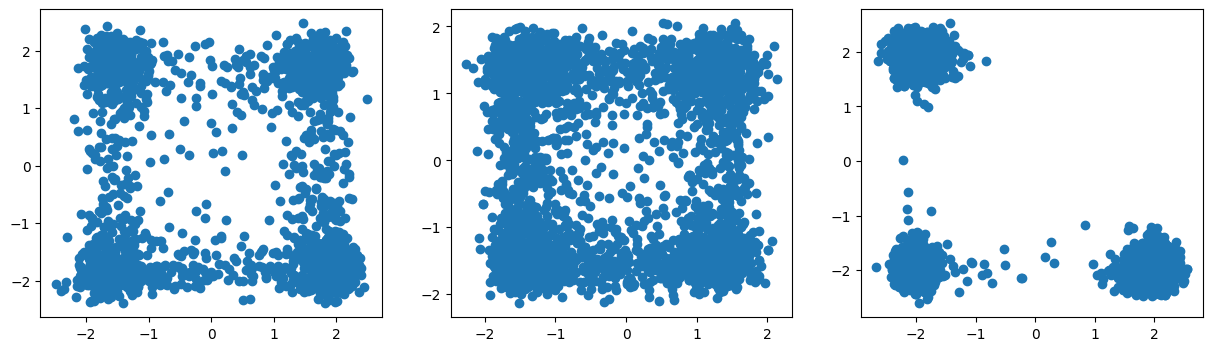

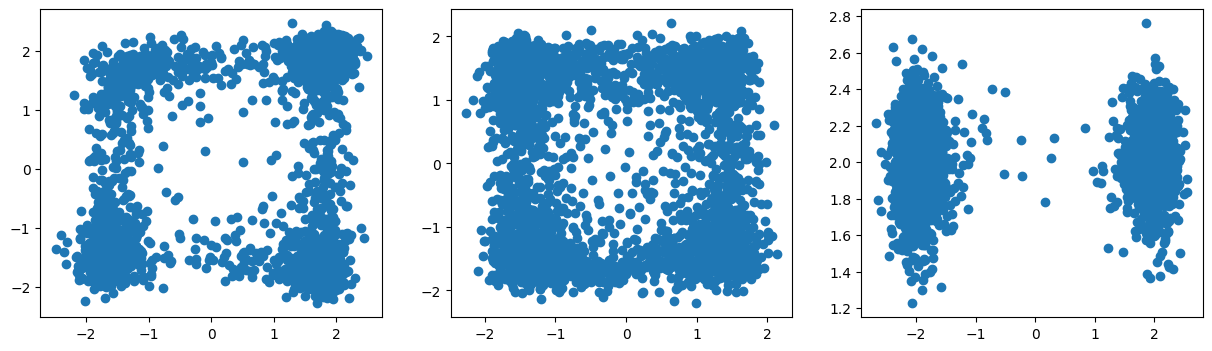

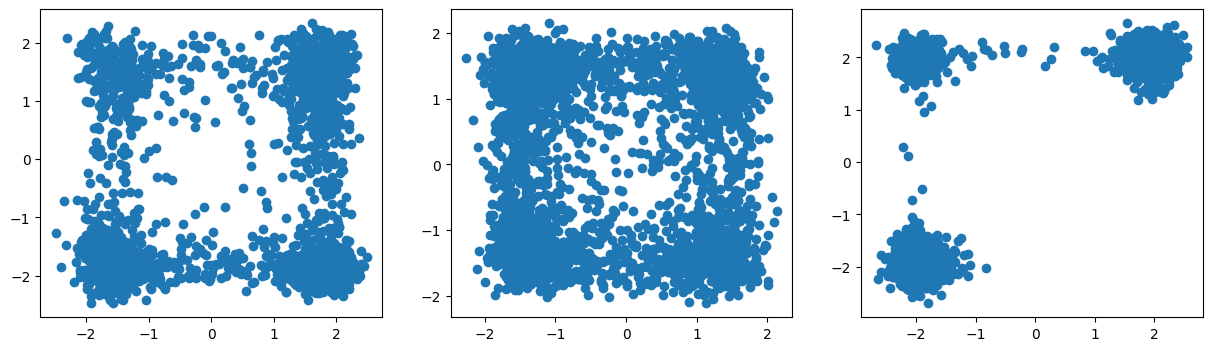

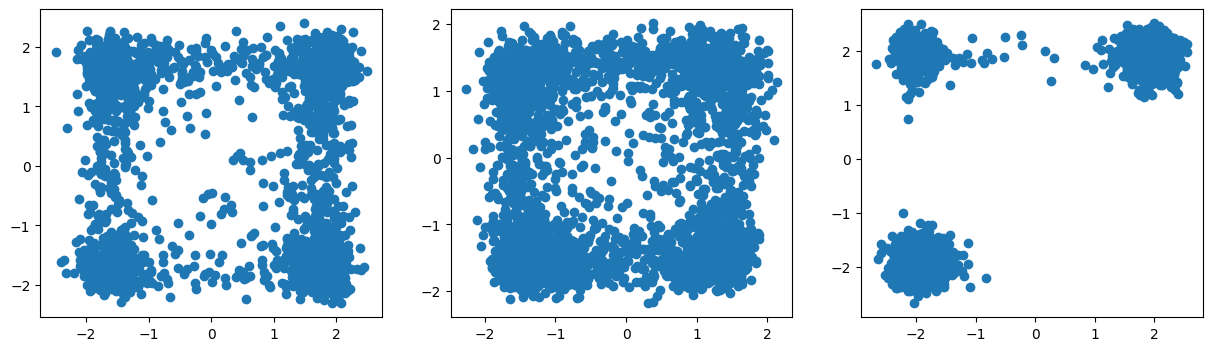

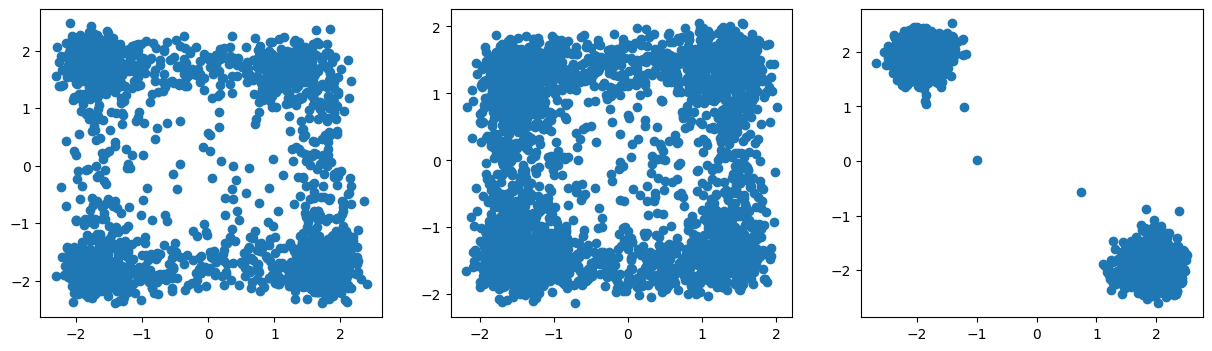

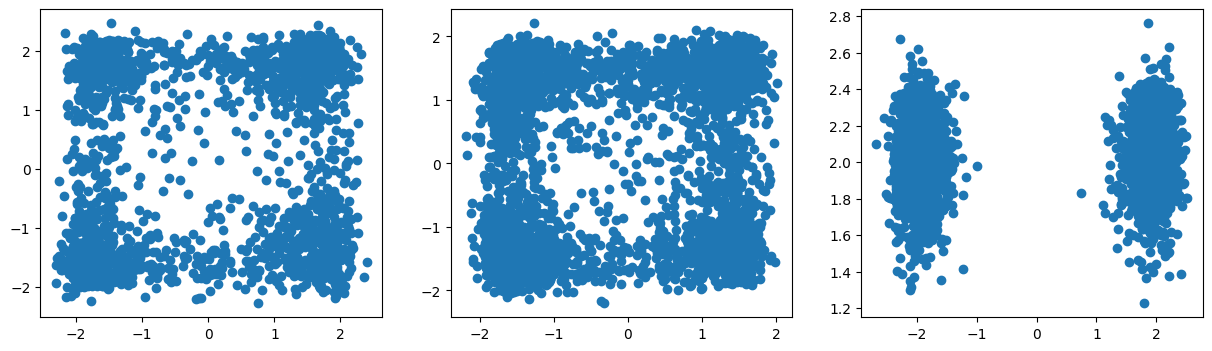

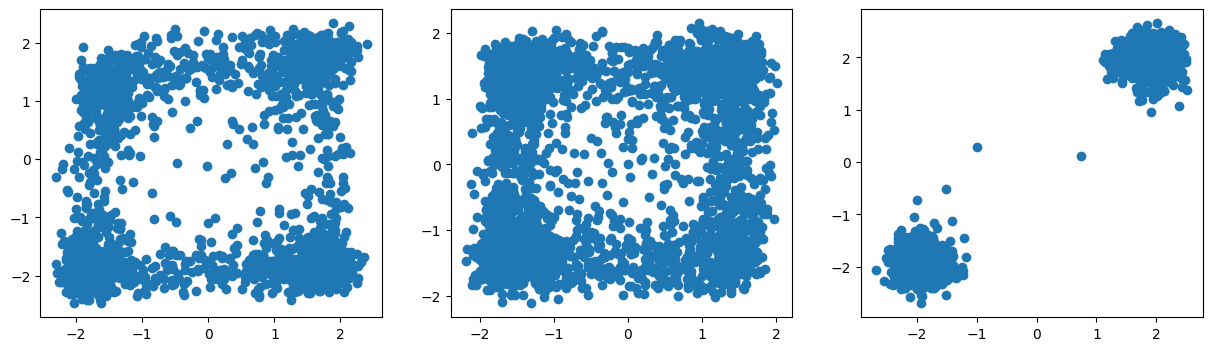

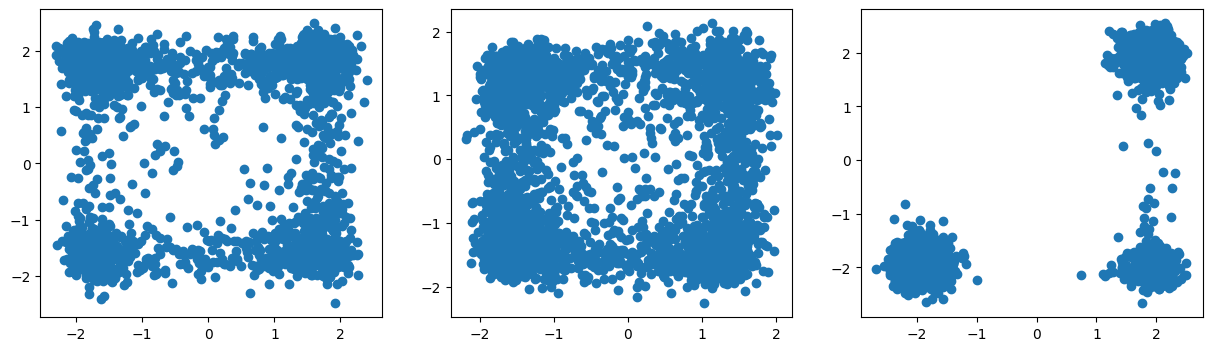

In [29]:
for i in range(5):
    for j in range(5):
        if i != j:
            fig = plt.figure(3, figsize=(15,4))
            subfig = fig.subplots(1, 3)
            subfig[0].scatter(samples.particles[:, i].detach().cpu().numpy(), samples.particles[:, j].detach().cpu().numpy())
            subfig[1].scatter(samples2.particles[:, i].detach().cpu().numpy(), samples2.particles[:, j].detach().cpu().numpy())
            subfig[2].scatter(samples3.particles[:, i].detach().cpu().numpy(), samples3.particles[:, j].detach().cpu().numpy())
            plt.show()